# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8
process_noise = 0.01
measurement_noise = 0.06

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

In [3]:
num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [4]:
Q_TT = 1e-4 * np.array([[1, 0], [0, 0]]) # mas^2, arbitrary

In [5]:
# now, let's import the usual Kalman filter!

size = 5000
N = 1
params = make_vibe_params(N=N)
vibe = make_1D_vibe_data(steps=size, N=N) + np.random.normal(0, process_noise * N, (size,))
pol = vibe
kfilter_vibe = make_kfilter_vibe(np.vstack((params[1:3])).T, np.array([process_noise] * 1))

Took 8 iterations to get steady-state covariance.


In [6]:
res, phy = kfilter_vibe.run(vibe + np.random.normal(0, measurement_noise, vibe.size), save_physics=True)

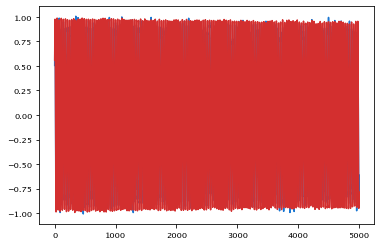

In [7]:
plt.plot(res)
plt.plot(vibe)

In [8]:
rms(res - vibe)

0.08455027116919107

In [9]:
kfilter_TT = KFilter(np.zeros(2,), A_TT, B_TT.flatten(), Q_TT, C_TT, np.array([eps]), has_input=True)
# the Q and R don't matter because I'm setting the Kalman gain to zero
kfilter_TT.K *= 0

Took 8 iterations to get steady-state covariance.


In [10]:
state_WFS = np.array([0, 0])
A_WFS = np.array([[0, 0], [1, 0]])
B_WFS = np.array([1, 0]) # takes in residual at timestep k
H_WFS = np.array([[0, 1]])
Q_WFS = np.identity(2) 
R_WFS = np.array([eps])
# the Q and R don't matter because I'm setting the Kalman gain to zero

kfilter_WFS = KFilter(state_WFS, A_WFS, B_WFS, Q_WFS, H_WFS, R_WFS, has_input=True)
kfilter_WFS.K *= 0

Took 1 iterations to get steady-state covariance.


In [11]:
kfilter = kfilter_WFS + kfilter_vibe + kfilter_TT
kfilter.H = np.array([[0, 1, 0]]).dot(kfilter.H)

In [12]:
N_WFS = 2 # two frame delay
N_vibe = kfilter_vibe.state.size
N_CM = 2 # second order control loop model
N_state = N_WFS + N_vibe + N_CM
N_frames = 4
B_temp = B_WFS.reshape((B_WFS.size,1))
temp1 = B_temp.dot(kfilter_vibe.H)
temp2 = -B_temp.dot(C_TT)

In [13]:
# hardcoding because some things are just plain weird
kfilter.B = np.array(([0] * (N_WFS + N_vibe)) + list(B_TT.flatten()))

In [14]:
for i, j in [(0, 2), (0, 3), (1, 2), (1, 3)]: # works with a hardcoded N_WFS = 2
    kfilter.A[i][j] = temp1[i][j-2]
    kfilter.A[i][j+2] = temp2[i][j-2]

In [15]:
# at this point, the filter should be set up properly
kfilter.state = np.zeros(kfilter.A.shape[0],)
delay = 2
res, phy = kfilter.run(pol[delay:] 
                       + np.random.normal(0, measurement_noise, (pol.size - delay,)), 
                       np.zeros(pol.size-delay,), save_physics=True)
# this works!

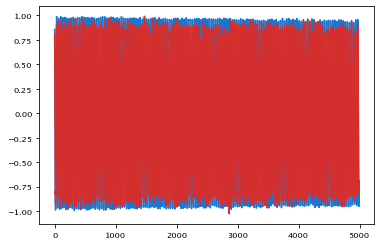

In [16]:
plt.plot(pol[kfilter.iters:])
plt.plot(res[kfilter.iters-delay:])

In [17]:
rms(pol[kfilter.iters:] - res[kfilter.iters-delay:])

0.08459253903336973

In [55]:
y, u = 50, 1
R_y = np.identity(N_frames) * y
R_u = np.identity(N_frames) * u
C_0 = np.vstack(([kfilter.H] + [kfilter.H.dot(kfilter.A ** i) for i in range(1, N_frames)]))
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        if i - j - 1 == 0:
            D_0[i][j] = kfilter.H.dot(kfilter.B)
        else:
            D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [56]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = float(max(np.diff(pol[:5000]))) # arbitrary
G = np.identity(N_frames)
G = np.vstack((np.identity(N_frames), -np.identity(N_frames)))
h = np.vstack([u_max] * (2 * N_frames))

In [57]:
kfilter.B

array([0., 0., 0., 0., 1., 0.])

In [58]:
solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')['x']

In [59]:
np.array(solution) # should be zero or almost zero, because the state's zero

array([[0.],
       [0.],
       [0.],
       [0.]])

In [60]:
pol[0]

0.5618639071411299

In [66]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
delay = 2

shifts = np.diff(pol)
res_control = np.zeros(pol.shape)
res_control[0] = pol[0]
actions = np.zeros(pol.shape)
for i in range(size):
    try:
        if i > 0:
            res_control[i] = res_control[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res_control[i] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        
        if i < pol.size - N_frames - 1 and i % N_frames == 0:
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='cvxopt')['x']
            for j in range(i, i + N_frames):
                actions[j] = -solution[j - i]
        
        kfilter.predict(actions[i - 1])
        
    except:
        print(i)
        raise

In [62]:
rms(pol[kfilter.iters:])

0.6789626446671883

In [63]:
rms(res_control[kfilter.iters:])

0.6789626446671883

(1e-10, 96.40807565456204)

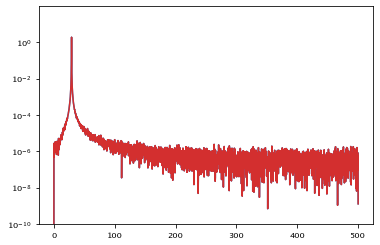

In [64]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.semilogy(*signal.periodogram(res_control, fs=f_sampling))
# plt.semilogy(*signal.periodogram(actions, fs=f_sampling))
plt.ylim(1e-10)

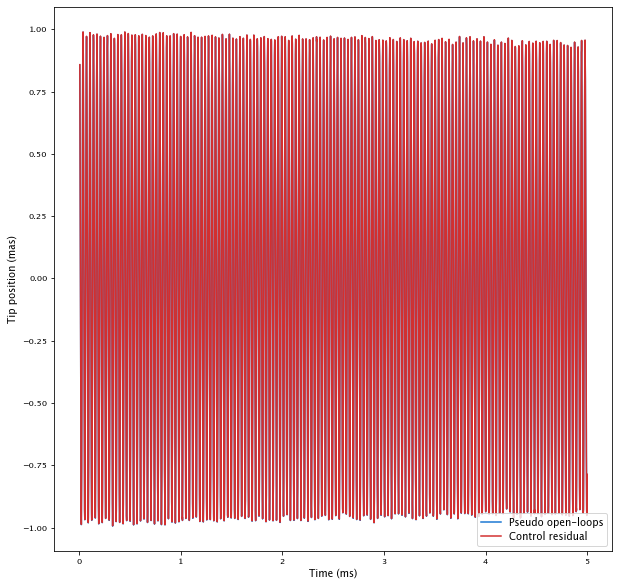

In [65]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), pol[kfilter.iters:], label='Pseudo open-loops')
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), res_control[kfilter.iters:] - np.mean(res_control[kfilter.iters:]), label='Control residual')
plt.xlabel("Time (ms)")
plt.ylabel("Tip position (mas)")
plt.legend()
plt.show()